# MD005 Tercer entregable: Regresión


## Procesado Inicial

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

import statsmodels.api as sm

import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif

from six import StringIO
import pydot
import warnings
from IPython.display import Image

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import time

Como todo el procesamiento de los datos ya se ha hecho en las entregas anteriores y para no ser repetitivo, haré un pequeño resumen de lo hecho en cuanto al tratamiento de los datos y a lo que se ha observado de estos.

In [3]:
dtf = pd.read_csv(r'C:\Users\josep\Downloads\data_all\data_all.csv', sep = ',', encoding = 'latin1', error_bad_lines=False) #error_bad_lines is avoid single line error

dtf = dtf.dropna()

remakes = dtf[dtf['total_blue_turrets'] == 0]
remakes = remakes[remakes['total_red_turrets'] == 0]

merged_df = dtf.merge(remakes, indicator=True, how='left')
dtf2 = merged_df[merged_df['_merge'] == 'left_only']
dtf = dtf2.drop(columns=['_merge'])

outlier = dtf[dtf['total_red_kills'] == 0]
outlier = outlier[outlier['winning_team'] == 1]

outlier_condition = (dtf['winning_team'] == 1) & (dtf['total_red_kills'] == 0)
dtf = dtf[~outlier_condition]

dtf_red = dtf.filter(regex='(red|winning_team)')
dtf_blue = dtf.filter(regex='(blue|winning_team)')
dtf_red.describe()

C:\Users\josep\AppData\Local\Temp\ipykernel_26212\4223797141.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dtf = pd.read_csv(r'C:\Users\josep\Downloads\data_all\data_all.csv', sep = ',', encoding = 'latin1', error_bad_lines=False) #error_bad_lines is avoid single line error


,total_red_barons,total_red_drakes,total_red_heralds,total_red_inhibs,total_red_kills,total_red_turrets,red_first_blood,red_first_herald,red_first_drake,red_first_baron,...,total_red_vs,total_red_gold,med_red_kills,med_red_xp,med_red_gold,med_red_dmg,red_got_soul,total_red_elders,med_red_vs,winning_team
count,258286.000000,258286.000000,258286.000000,258286.000000,258286.000000,258286.000000,258286.000000,258286.000000,258286.000000,258286.000000,...,258286.000000,258286.000000,258286.000000,258286.000000,258286.000000,258286.000000,258286.000000,258286.000000,258286.000000,258286.000000
mean,0.363105,0.504250,0.463482,0.402568,0.496255,0.493927,0.488586,0.462518,0.512444,0.362807,...,0.496957,0.499357,0.492156,0.500310,0.499193,0.497810,0.120940,0.022543,0.498273,0.495273
std,0.455714,0.353926,0.431874,0.464142,0.154863,0.318068,0.499871,0.498594,0.499846,0.480811,...,0.066928,0.053830,0.184858,0.048040,0.056496,0.085000,0.326058,0.146505,0.075722,0.499979
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.025000,0.308279,0.000000,0.264141,0.260425,0.122982,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.250000,0.000000,0.000000,0.375000,0.214286,0.000000,0.000000,0.000000,0.000000,...,0.453202,0.455484,0.360000,0.458405,0.454576,0.436846,0.000000,0.000000,0.449664,0.000000
50%,0.000000,0.500000,0.500000,0.000000,0.495327,0.500000,0.000000,0.000000,1.000000,0.000000,...,0.496970,0.498765,0.500000,0.499725,0.499009,0.497695,0.000000,0.000000,0.500000,0.000000
75%,1.000000,0.800000,1.000000,1.000000,0.617021,0.769231,1.000000,1.000000,1.000000,1.000000,...,0.540741,0.543332,0.625000,0.542484,0.543863,0.558497,0.000000,0.000000,0.547059,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.906250,0.697141,1.000000,0.827078,0.714896,0.955552,1.000000,1.000000,1.000000,1.000000


En el codigo anterior he juntado todo el tratamiento de datos realizado en las previas entregas donde veiamos como los datos no tienen ningun valor nulo y me deshacia de los outliers de mi dataset descartando aquellas partidas que muy posiblemente habian sido remakes y algun valor más que no tenia demasiado sentido.

En los analisis exploratorios de los datos en las anteriores entregas vimos como el test anova no aportaba demasiada información en cuánto a las variables, cosa que no nos afecta en lo más minimo ya que aplicaremos algoritmos de regresión a variables continuas y el test ANOVA no iba a aportar ninguna información igualmente. También vimos como en la PCA y analisis de factores, a partir del segundo componente la varianza explicada de nuevos componentes era practicamente negligible y en general, vimos que conseguiamos poca varianza explicada y con la PCA se perdia bastante información así que los resultados no eran del todo significativos por lo que decidí que no le haria demasiado caso.

En cuanto al analisis de correlaciones y entropías, los repetiré ya que para la regresión tocará decidir una nueva variable objetivo para la cual realizar las predicciones ya que la variable objetivo que he usado en las anteriores entregas era categórica.

Hasta el momento en las entregas previas ha quedado muy claro que lo que más influia en la probabilidad de victoria era el oro generado, así que para esta entrega veo dos posibles objetivos/ideas para las cuales realizar la regresión, la primera seria usando la misma varible objetivo de winning_team junto con las ya usadas previamente, para realizar un analisis de las partidas y determinar con que probabilidad esa partida seria una victoria o una derrota. La segunda, sería un modelo de regresión en el cual fuera capaz de predecir que porcentage de oro se ha generado en la partida a través del resto de variables, ya que sabemos que el oro descaradamente influye en la victoria, pero no sabemos que deberiamos priorizar en una partida para generar este oro.

Finalmente he decidido perseguir la segunda opción ya que esta será mas fácil de evaluar en cuánto a la efectividad de la regresión y el hecho de que la variable de oro generado sea la dependiente ya hablando linguísticamente tiene mucho sentido ya que el oro depende (jeje) de las cosas que hagas en la partida como asesinatos, torres, etc...

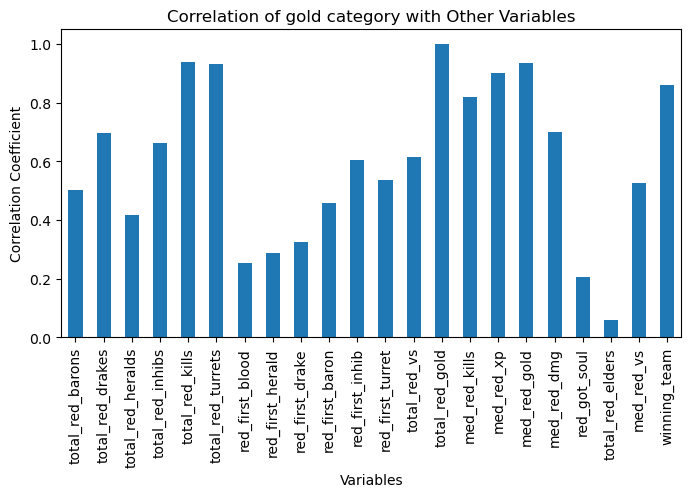

total_red_drakes     0.695488
total_red_inhibs     0.660944
total_red_kills      0.938275
total_red_turrets    0.933449
red_first_inhib      0.604671
total_red_vs         0.614977
med_red_kills        0.817690
med_red_xp           0.899762
med_red_gold         0.935178
med_red_dmg          0.698462
winning_team         0.859677
Name: total_red_gold, dtype: float64

In [14]:
correlation_matrix = dtf_red.corr()
variable1_correlations = correlation_matrix.loc['total_red_gold']

plt.figure(figsize=(8, 4))
variable1_correlations.plot(kind='bar')
plt.title('Correlation of gold category with Other Variables')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.show()

target_correlation = correlation_matrix['total_red_gold']
significant_correlations = target_correlation[abs(target_correlation) > 0.6].drop('total_red_gold', errors='ignore')
significant_correlations

In [16]:
significant_correlations.drop(['med_red_kills', 'med_red_gold', 'red_first_inhib'])

total_red_drakes     0.695488
total_red_inhibs     0.660944
total_red_kills      0.938275
total_red_turrets    0.933449
total_red_vs         0.614977
med_red_xp           0.899762
med_red_dmg          0.698462
winning_team         0.859677
Name: total_red_gold, dtype: float64

Como observamos, las variables que más se relacionan con la variable objetivo son más o menos las mismas que he estado usando en las entregas, aqui habrá que tener cuidado tambien a la hora de crear el modelo, tratando de usar variables que no tengan una alta colinealidad.

Fuera de eso, las variables tienen mucho sentido, puesto que las torres y los asesinatos són lo que genera más oro junto con el farm.

In [19]:
from sklearn.ensemble import RandomForestRegressor

X = dtf_red.drop('total_red_gold', axis=1)  # Variables independientes
y = dtf_red['total_red_gold']  # Variable objetivo

# Ajustar el modelo
model = RandomForestRegressor()
model.fit(X, y)

# Obtener la importancia de las variables
feature_importance = pd.Series(model.feature_importances_, index=X.columns)

# Ordenar las características por importancia
feature_importance = feature_importance.sort_values(ascending=False)

print(feature_importance)

winning_team         0.739036
total_red_kills      0.131254
med_red_gold         0.048946
total_red_turrets    0.043234
med_red_xp           0.017868
med_red_dmg          0.003712
total_red_vs         0.003661
med_red_kills        0.003311
med_red_vs           0.003129
total_red_barons     0.001474
total_red_drakes     0.001212
total_red_heralds    0.000699
red_first_blood      0.000432
red_first_turret     0.000392
total_red_inhibs     0.000362
red_first_herald     0.000348
red_first_drake      0.000292
red_got_soul         0.000211
red_first_inhib      0.000179
red_first_baron      0.000164
total_red_elders     0.000085
dtype: float64


El analisis de la importancia de las variables se centra en entender qué tan influyentes son las variables independientes en la predicción de la variable objetivo. Aqui podemos observar que el analisis nos muestra que la variable más influyente sin dar lugar a dudas es el winning team, sin embargo, esta, al ser una variable categorica binaria, en el momento de predecir el oro, aportará información muy inconcluyente. Es decir se ha ganado la partida, pero para esta variable una partida del 80% del oro y una del 55% siguen teniendo un valor de 1.

In [21]:
from sklearn.feature_selection import mutual_info_regression

# Calcular la información mutua
mi = mutual_info_regression(X, y)

# Convertir los resultados en una Serie de pandas para una visualización más clara
mi_series = pd.Series(mi, index=X.columns)

# Ordenar los resultados
mi_series = mi_series.sort_values(ascending=False)

print(mi_series)

med_red_gold         2.713208
med_red_xp           2.543862
med_red_dmg          2.158675
total_red_kills      2.033496
total_red_vs         1.728391
total_red_turrets    1.491744
med_red_vs           1.200894
med_red_kills        1.175191
total_red_drakes     0.708793
winning_team         0.631336
total_red_inhibs     0.559723
total_red_barons     0.422923
red_first_inhib      0.337208
red_first_baron      0.270604
red_first_turret     0.252545
total_red_heralds    0.246257
red_first_drake      0.147233
red_first_herald     0.138838
red_first_blood      0.130518
red_got_soul         0.113284
total_red_elders     0.031533
dtype: float64


El analisis de informacion mutua ya nos muestra algo con un poco más de sentido y nos dice que las variables que mayor informacion aportan a nuestra variable objetivo son la experiiencia, el daño y las kills. Obviamente el daño y las kills estaran altamente correlacionados por lo que a la hora de crear el modelo deberiamos considerar si es buena idea usar ambas. De momento me quedaré con las 5 variables que muestran una mayor relacion con la variable.

<Figure size 500x2000 with 0 Axes>

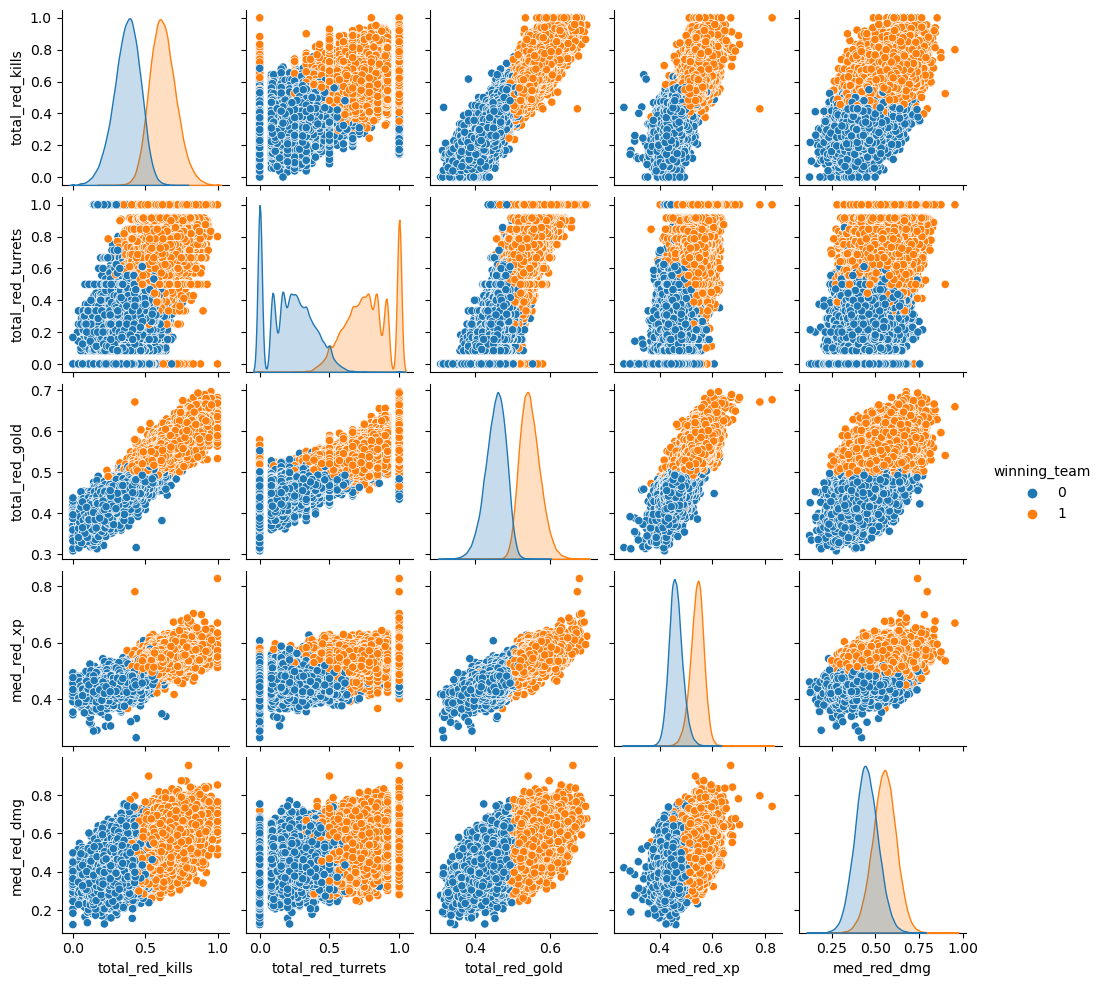

In [26]:
data = dtf_red[['total_red_kills', 'total_red_turrets', 'total_red_gold', 
                'winning_team', 'med_red_xp', 'med_red_dmg']]
plt.figure(figsize = (5, 20))
sns.pairplot(data,  hue='winning_team', height=2, palette = "tab10")
plt.show()

Por los scatterplots podemos deducir que la experiencia y las kills a primera vista ya parecen explicar en gran medida el oro.

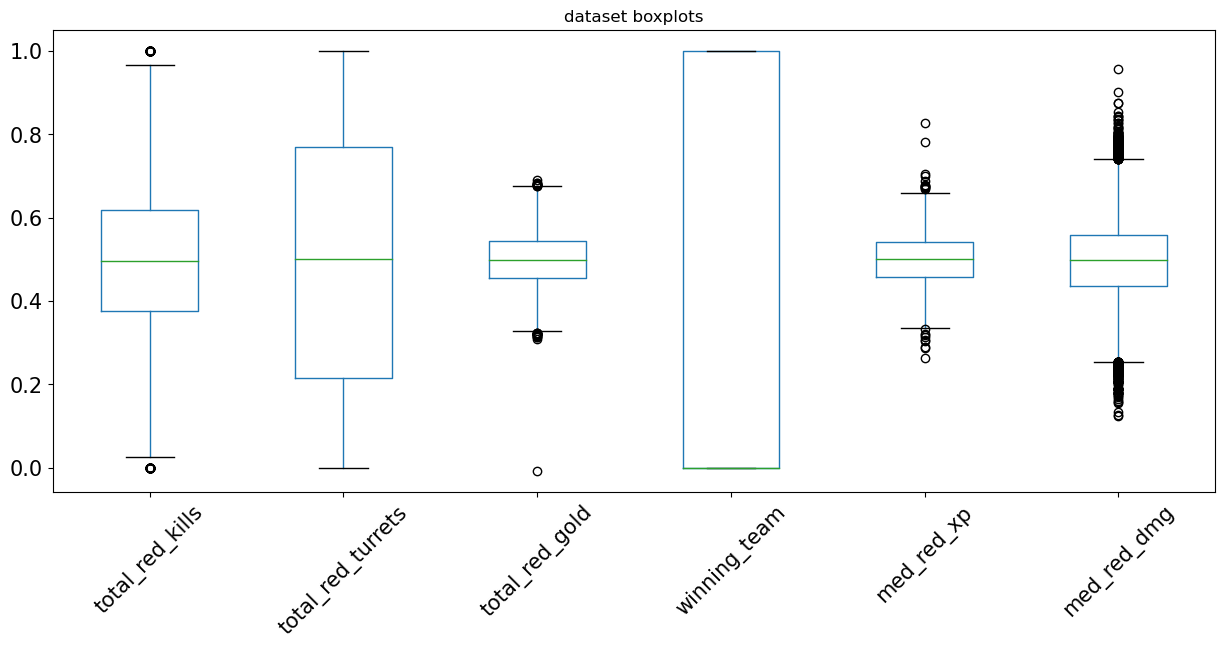

In [138]:
plt.figure(figsize = (15, 6))
plt.title("dataset boxplots")
data.boxplot(grid=False, rot=45, fontsize=15)
plt.show()

Los boxplots, por la naturaleza de los datos no aportan demasiado información. Todas las variables tienen un rango de valores de 0 a 1 tal y como se ha comentado anteriormente, a excepción del oro, la experiencia y el daño que tienen un rango menor ya que es imposible generar el 100% de ellos en la partida. Además vemos como la media de las variables es practicamente la mediana en todos los casos y eso denota una distribución bastante equitativa de las muestras.

C:\Users\josep\AppData\Local\Temp\ipykernel_26212\1826911438.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(ax = ax)


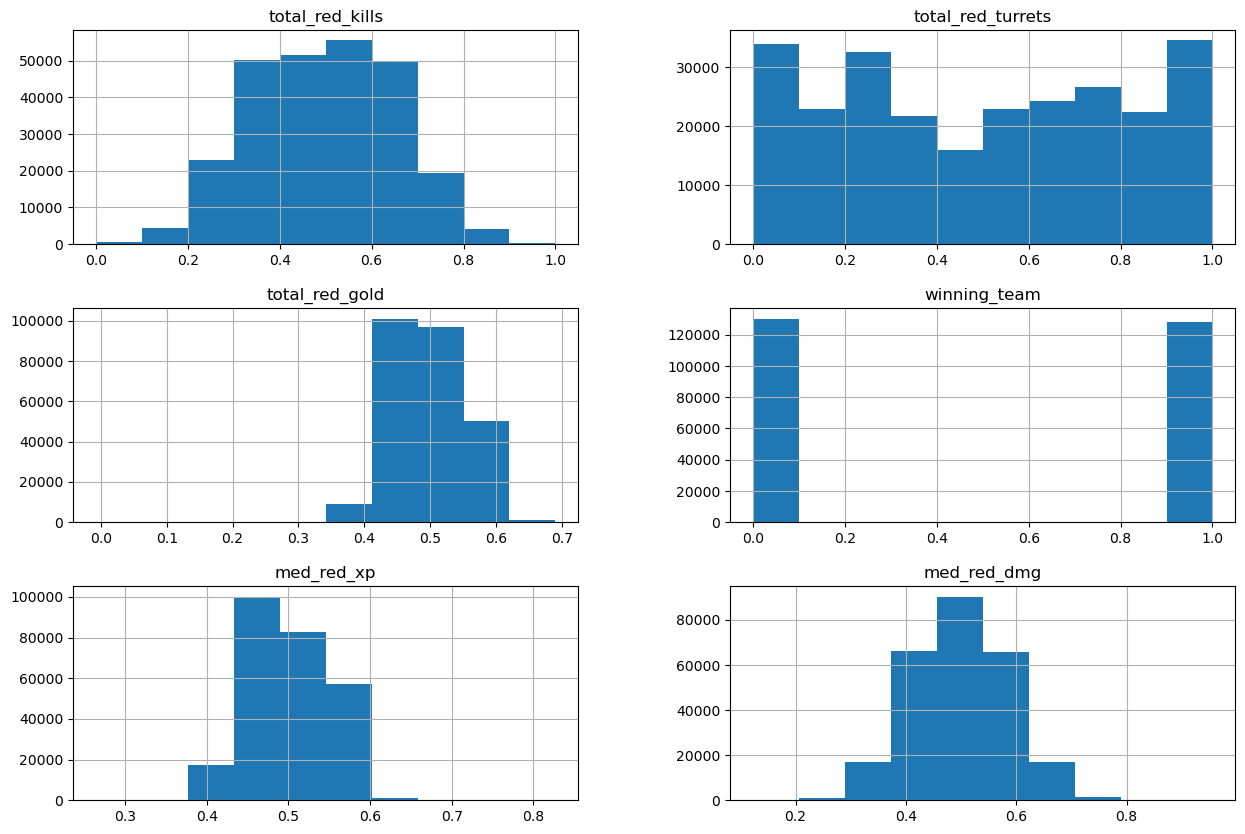

In [139]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
data.hist(ax = ax)
plt.show()

Como ya vimos en la entrega previa, las variables de oro y kills siguen distribuciones muy bonitas y parecidas a una normal, al igual que la de experiencia y el daño y eso nos gusta puesto que esto nos permite realizar inferencias estadísticas válidas y fiables, como tests de hipótesis y la construcción de intervalos de confianza.

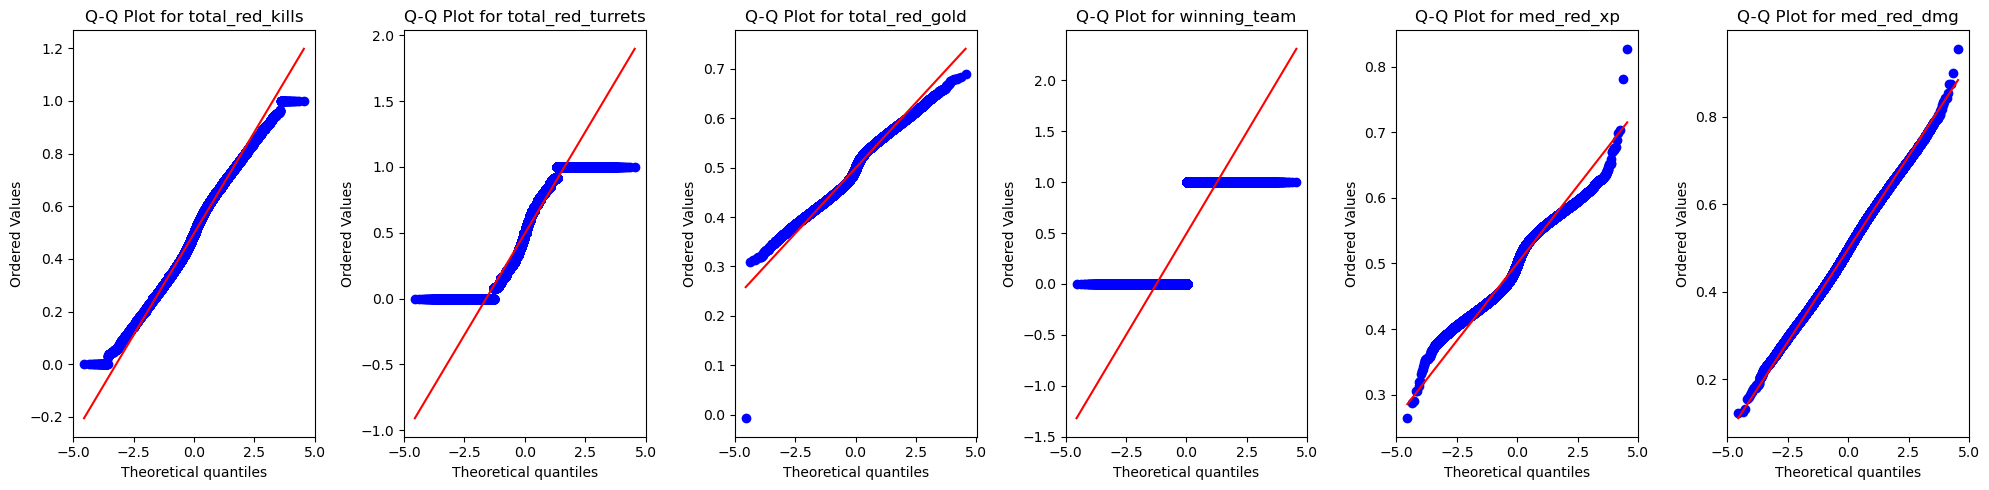

In [142]:
fig, axes = plt.subplots(1, len(data.columns), figsize=(20, 5))  # Ajusta el tamaño según tus necesidades

# Generar un gráfico Q-Q para cada columna
for ax, col in zip(axes, data.columns):
    stats.probplot(data[col], dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot for {col}')

plt.tight_layout()
plt.show()

Efectivamente, vemos como las variables de experiencia, kills y oro estan muy cerca de la recta que determina la normalidad, pero la que más llama la atención es la variable de daño, que tiene una normalidad casi perfecta.

### Conclusiones Variables

Como he explicado, finalmente me he decantado por la opción de usar el oro como variable objetivo para de este modo tambien averiguar que es lo más influyente al para obtenerlo y así ser capaz de priorizarlo en mis proximas partidas para intentar salir del pozo (pista: no saldré ni en 100 años).

Como se ha observado las variables que muestran una mayor correlacion con mi variable objetvio son mayormente aquellas con las que ya he trabajado en las entregas anteriores además de la experiencia que hasta ahora no habia usado. La forma en la que plantearé las regresiones sera tratando de generar un modelo simple con una sola variable independiente para así evitar cualquier problema de colinealidad, y después generaré otro modelo con 3 o 4 variables independientes para evaluar cual de los dos modelos se ajusta mejor.

Una vez creados los modelos los evaluaré, y trataré de conseguir la mejor combinación de hiperparámetros, como el número de grados en la regresión polinomica por ejemplo.

## Regresión

In [130]:
num_rows = data.shape[0]
num_to_remove = int(num_rows * 0.1)  # 10% de las filas

# Seleccionar aleatoriamente índices para eliminar
indices_to_remove = np.random.choice(data.index, num_to_remove, replace=False)

# Establecer esos valores a NaN
data.loc[indices_to_remove, 'total_red_gold'] = np.nan

Antes que nada elimino el 10% de los valores de mi variable objetivo para el ejercicio optativo.

### Regresión lineal sencilla

In [56]:
data2 = data.dropna()
X = data2[['total_red_kills']]
y = data2['total_red_gold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Algoritmo
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicción y evaluación
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Root Mean squared error:', np.sqrt(mse))
print('R-squared:', r2)

Root Mean squared error: 0.018710861190028332
R-squared: 0.8796529988256604


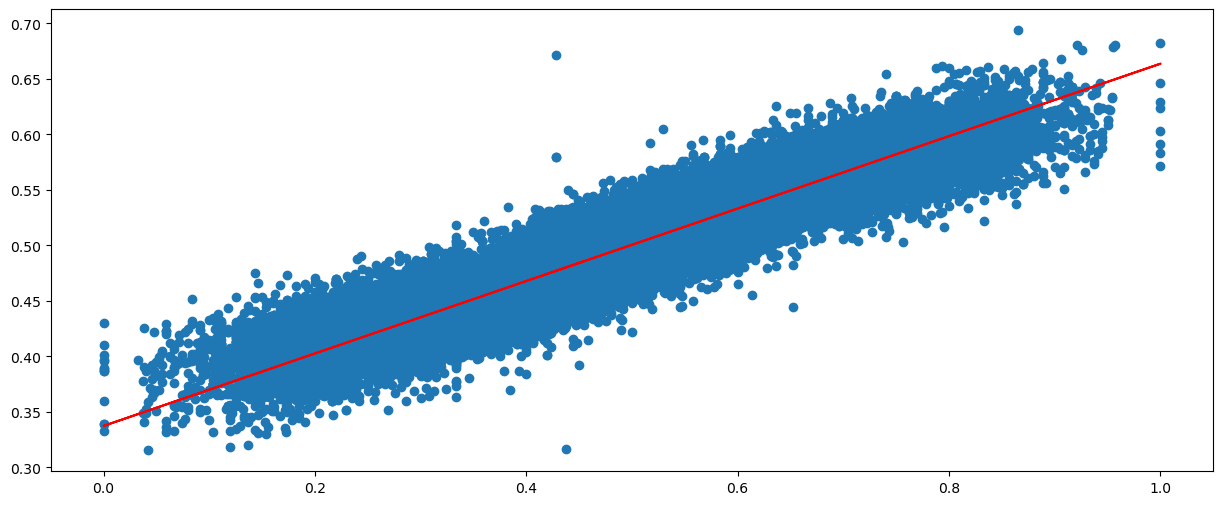

In [31]:
plt.figure(figsize = (15, 6))
plt.scatter(X_test, y_test, label = "Testing points")
plt.plot(X_test, y_pred, label = "Predicted points", c = 'r')
plt.show()

Este primer modelo se ajusta bastante bien y con no demasiado error, pero como vemos puede ser un poco dificil de predecir algo solo con una variable dado el mar de puntos que tengo.

In [120]:
X = data2[['total_red_kills', 'total_red_turrets', 'med_red_xp']]
y = data2['total_red_gold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

start_time = time.time()

regressor = LinearRegression()
regressor.fit(X_train, y_train)

end_time = time.time()
duration = end_time - start_time
print(f"El modelo tardó {duration} segundos en entrenarse.")

y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Root Mean squared error:', np.sqrt(mse))
print('R-squared:', r2)

El modelo tardó 0.01396489143371582 segundos en entrenarse.
Root Mean squared error: 0.01120892471713001
R-squared: 0.9568107538422687


Efectivamente, con 3 variables el modelo se ha ajustado mucho mejor con un r-squared realmente alto con el que se podria trabajar y obtenemos un tiempo de entrenamiento prácticamente inapreciable.

In [39]:
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         total_red_gold   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                 1.203e+06
Date:                Sat, 03 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:15:29   Log-Likelihood:             5.0042e+05
No. Observations:              162720   AIC:                        -1.001e+06
Df Residuals:                  162716   BIC:                        -1.001e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2666      0.00

Aqui observamos que para el modelo la variable que ha aportado una mayor informacion ha sido la experiencia, cosa que realmente me sorprende dado que la experiencia es lo único que a priori no tiene una relacion directa con el oro, ya que tanto los asesinatos como las torres dan oro, pero la experiencia no. Así que aqui tenemos una clara relacion de correlaciones sin causalidad.

### Regresión polinomica

In [75]:
from sklearn.preprocessing import PolynomialFeatures

X = data2[['total_red_kills']]
y = data2['total_red_gold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

y_pred = poly_model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Root Mean squared error:', np.sqrt(mse))
print('R-squared:', r2)

Root Mean squared error: 0.018186484954541112
R-squared: 0.8863039820290943


Al crear este modelo solo con la misma variable independiente de antes y un grado de 3, era de esperar que el resultado fuera parecido al del primer modelo de regresión lineal.

C:\Users\josep\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


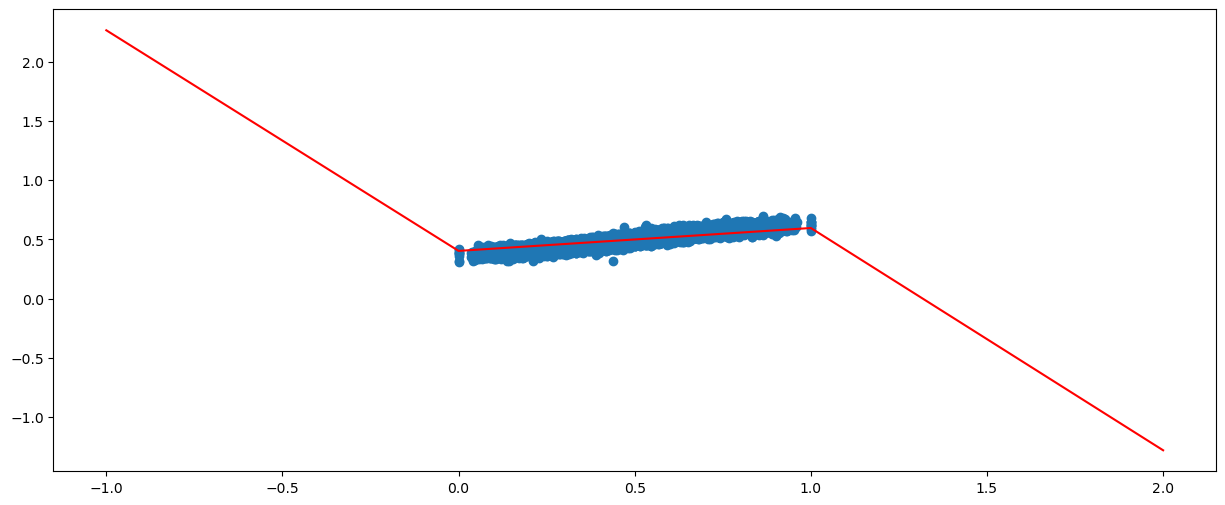

In [80]:
new_x = np.arange(-1, 3).reshape(-1, 1)
new_x2 = poly.transform(new_x)

pred = poly_model.predict(new_x2)

plt.figure(figsize = (15, 6))
plt.scatter(X_test, y_test, label = "Testing points")
plt.plot(new_x, pred, label = "Predicted points", c = 'r')
plt.show()

Aunque se aprecie bastante mal, observamos los 3 grados de la regresion y como entre 0 y 1 sea ajusta a nuestros datos.

In [136]:
X = data2[['total_red_kills', 'total_red_turrets', 'med_red_xp']]
y = data2['total_red_gold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

y_pred = poly_model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Root Mean squared error:', np.sqrt(mse))
print('R-squared:', r2)

Root Mean squared error: 0.010817062502862504
R-squared: 0.959777746627378


Al igual que en el caso anterior, con 3 variables el modelo se ha ajustado mucho mejor con un r-squared parecido. A continuación voy a tratar de encontrar cual es el grado para la funcion polinomica que mejor se adapte a mis datos.

In [62]:
#Se define el grado del polinomio
max_degree = 10
dataC=pd.DataFrame()
for degree in range(1,max_degree+1):
    # Transforming data to include polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)

    # Fitting the model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Predicting and evaluating the model
    y_pred = model.predict(X_test_poly)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    datad=pd.DataFrame({'Degree':[degree],'RMSE':[rmse],'Coefficients':[model.coef_[0]]})
    dataC=pd.concat([dataC,datad]).reset_index(drop=True)
    print(f"Degree: {degree}, RMSE: {rmse}, R-squared: {r2}")

Degree: 1, RMSE: 0.011208924717130015, R-squared: 0.9568107538422687
Degree: 2, RMSE: 0.011209414680552117, R-squared: 0.9568069779915288
Degree: 3, RMSE: 0.010817062502862504, R-squared: 0.959777746627378
Degree: 4, RMSE: 0.010821724962134365, R-squared: 0.9597430653015597
Degree: 5, RMSE: 0.010735077676297599, R-squared: 0.9603851421756296
Degree: 6, RMSE: 0.010791023407257985, R-squared: 0.9599711615209717
Degree: 7, RMSE: 0.02077448430111085, R-squared: 0.8516429384761074
Degree: 8, RMSE: 0.022184731765119134, R-squared: 0.8308172487273949
Degree: 9, RMSE: 0.101397693289849, R-squared: -2.534303735421697
Degree: 10, RMSE: 0.3314127583638853, R-squared: -36.75601638961202


Como vemos el mejor resultado se obtiene con una polinomica de grado 5 donde mejoramos el r-squared por 0.004 respecto al mejor modelo obtenido con la regresion lineal.

In [127]:
X = data2[['total_red_kills', 'total_red_turrets', 'med_red_xp']]
y = data2['total_red_gold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

start_time = time.time()

poly = PolynomialFeatures(degree=5)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

end_time = time.time()
duration = end_time - start_time
print(f"El modelo tardó {duration} segundos en entrenarse.")

X_train_poly_const = sm.add_constant(X_train_poly) 
model = sm.OLS(y_train, X_train_poly_const).fit()
print(model.summary())

El modelo tardó 0.4421355724334717 segundos en entrenarse.
                            OLS Regression Results                            
Dep. Variable:         total_red_gold   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                 7.137e+04
Date:                Sun, 04 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:59:29   Log-Likelihood:             5.0700e+05
No. Observations:              162720   AIC:                        -1.014e+06
Df Residuals:                  162664   BIC:                        -1.013e+06
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

Debido a los múltiples grados, entender algo del peso de las variables independientes es más bien complicado, nos quedaremos con el r-squared y que la kurtosis de este modelo es menor a la del anterior. Además, al igual que con la regresion lineal, el modelo ha sido realmente rápido, aunque haya tardado más de 3 veces que el susodicho.

### Árboles de regresión

C:\Users\josep\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\josep\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


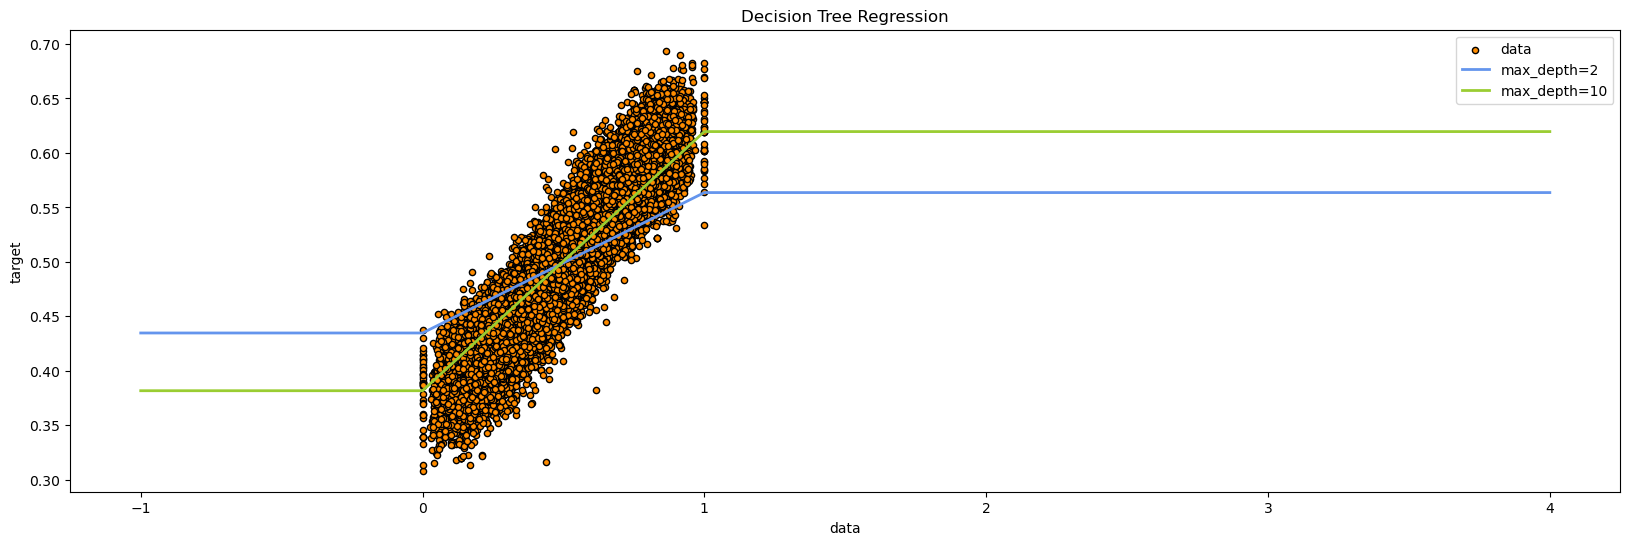

In [84]:
from sklearn.tree import DecisionTreeRegressor

X = data2[['total_red_kills']]
y = data2['total_red_gold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=10)
regr_1.fit(X, y)
regr_2.fit(X, y)

# X_test = X_test.sort_values(by = 'worst radius', ascending = True)

X_test2 = np.arange(-1, 5).reshape(-1, 1)

y_1 = regr_1.predict(X_test2)
y_2 = regr_2.predict(X_test2)

plt.figure(figsize = (20, 6))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test2, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test2, y_2, color="yellowgreen", label="max_depth=10", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

Aqui vemos como la profundidad que mejor se adapta es la de 10, que se ajusta bastante bien a la forma de nuestros datos.

In [85]:
y_2 = regr_2.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_2))
r2 = r2_score(y_test, y_2)

print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Root Mean Squared Error: 0.01783833308123858
R-squared: 0.8906153813731486


En cuestión de modelos simples de una sola variable independiente, este es el mejor resultado conseguido, con un árbol de 10 niveles. A continuación veremos si el árbol de 2 niveles se ha ajustado igual de bien, aunque por lo visto en el gráfico probablemente no sea el caso.

In [86]:
y_1 = regr_1.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_1))
r2 = r2_score(y_test, y_1)

print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Root Mean Squared Error: 0.022670588294057565
R-squared: 0.8233257325415171


En efecto, 10 niveles se ajustan mucho mejor que 2.

El modelo tardó 0.3160288333892822 segundos en entrenarse.


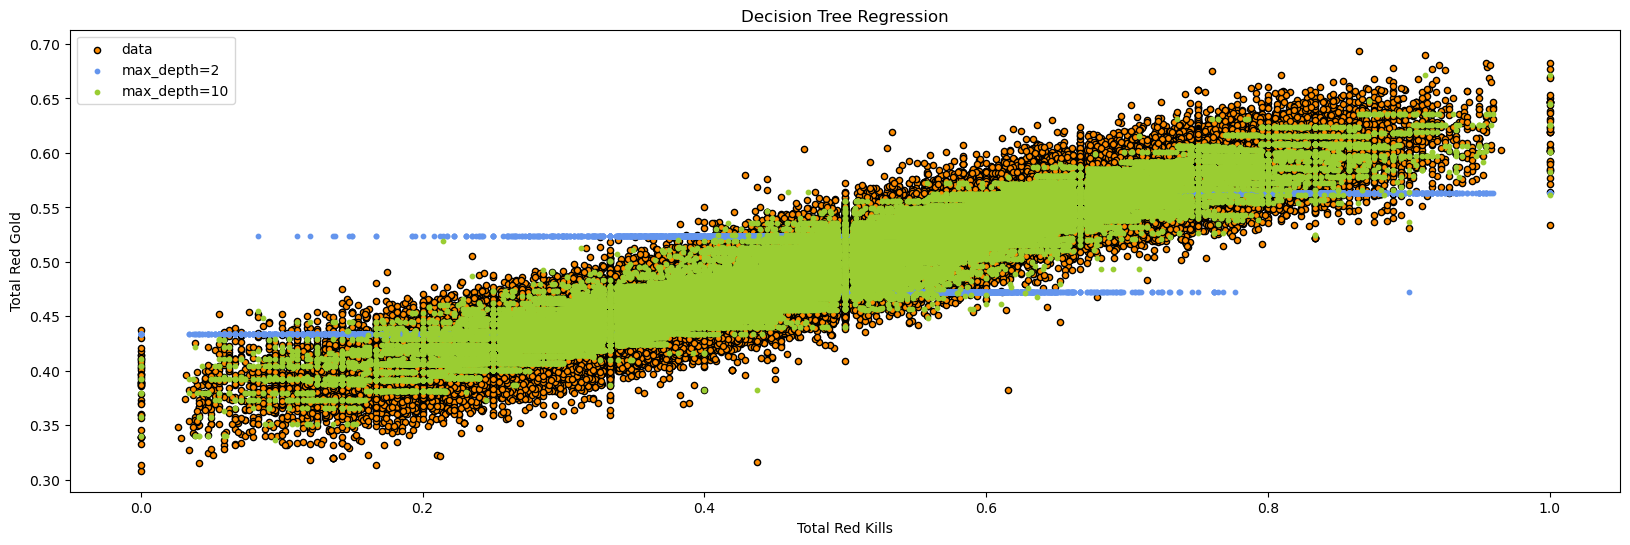

In [122]:
X = data2[['total_red_kills', 'total_red_turrets', 'med_red_xp']]
y = data2['total_red_gold']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

start_time = time.time()

regr_2 = DecisionTreeRegressor(max_depth=10)
regr_2.fit(X_train, y_train)
y_2 = regr_2.predict(X_test)


end_time = time.time()
duration = end_time - start_time
print(f"El modelo tardó {duration} segundos en entrenarse.")

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_1.fit(X_train, y_train)
y_1 = regr_1.predict(X_test)


# Visualización
plt.figure(figsize=(20, 6))
plt.scatter(X['total_red_kills'], y, s=20, edgecolor="black", c="darkorange", label="data")
plt.scatter(X_test['total_red_kills'], y_1, color="cornflowerblue", label="max_depth=2", s=10)
plt.scatter(X_test['total_red_kills'], y_2, color="yellowgreen", label="max_depth=10", s=10)
plt.xlabel("Total Red Kills")
plt.ylabel("Total Red Gold")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

Este es el gráfico del árbol usando 3 variables independientes, y como se aprecia (no se aprecia un carajo) el color verde, que simboliza el ajuste del modelo de 10 niveles, parece ajustarse bastante a los datos. Otra cosa interesante es que ha tardado menos en entrenarse que el modelo de regresion polinomica.

In [93]:
rmse = np.sqrt(mean_squared_error(y_test, y_2))
r2 = r2_score(y_test, y_2)

print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Root Mean Squared Error: 0.010971681810491591
R-squared: 0.9586196530691385


Aunque si bien es un gran resultado, no ha podido superar a lo obtenido con la regresión polinomica, además de que es bastante más dificil de comprender.

In [95]:
print('Profundidad del árbol:', regr_2.get_depth())
print('Número de hojas:', regr_2.get_n_leaves())

# También puedes mostrar la importancia de las características
print('Importancia de las características:', regr_2.feature_importances_)

Profundidad del árbol: 10
Número de hojas: 1020
Importancia de las características: [0.1612855  0.79260765 0.04610685]


Aqui observamos la importancia de cada una de las variables en este modelo y esta vez si que le veo mucho mas sentido a lo que vemos, siendo las torres lo que más importancia e informacion aporta y la experiencia lo que menos.

## Optativo

Para este ejercicio optativo lo primero que teniamos que hacer era crear un modelo de clasificacion con los datos sin los valores nulos que habiamos forzado anteriormente.

In [99]:
from sklearn.tree import DecisionTreeClassifier

data_bin = data2[['total_red_kills', 'total_red_turrets', 'total_red_gold', 'winning_team']]

X = data_bin.drop('winning_team', axis=1)
y = data_bin['winning_team']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model_params={
    'max_leaf_nodes':[50,100,500,5000],
    'min_samples_split':[2,4,6]
}

model = DecisionTreeClassifier(random_state=1234)
gscv = GridSearchCV(model, model_params, cv =3)
model_gs = gscv.fit(X_train, y_train)
print("Best: %f using %s" % (model_gs.best_score_,model_gs.best_params_))

Best: 0.980928 using {'max_leaf_nodes': 50, 'min_samples_split': 2}


In [100]:
model = DecisionTreeClassifier(max_leaf_nodes=50, min_samples_split=2, criterion='entropy')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

Una vez creado el modelo toca generar la matriz de confusion para poder compararla con la del modelo con datos autogenerados.

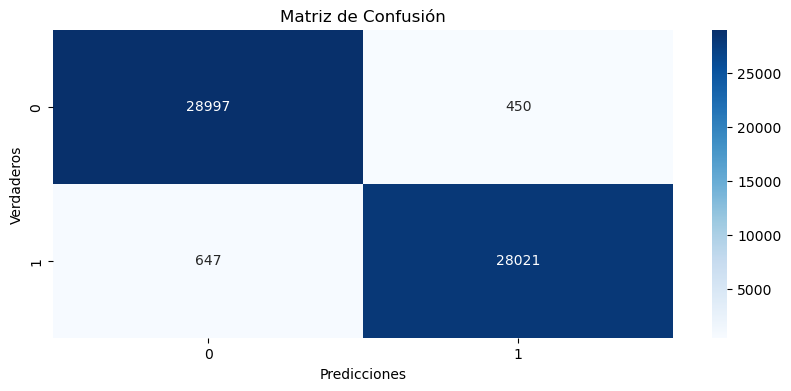

In [101]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.show()

In [131]:
df_missing_values = data[data['total_red_gold'].isnull()]
df_missing_values

,total_red_kills,total_red_turrets,total_red_gold,winning_team,med_red_xp,med_red_dmg
37,0.250000,0.166667,NaN,0,0.425796,0.450437
39,0.111111,0.000000,NaN,0,0.421978,0.369288
52,0.606557,0.833333,NaN,1,0.520617,0.473450
67,0.702128,0.818182,NaN,1,0.570998,0.585742
87,0.593750,0.777778,NaN,1,0.543599,0.486356
...,...,...,...,...,...,...
261318,0.261905,0.153846,NaN,0,0.438002,0.413438
261322,0.426667,0.444444,NaN,0,0.451751,0.343052
261342,0.603774,0.727273,NaN,1,0.516700,0.651434
261354,0.413793,0.153846,NaN,0,0.442346,0.429203


A continuacion rellenaré todos los valores nulos que observamos en la celda de arriba usando el modelo de regresion polinomica que he creado anteriormente.

In [132]:
X_missing = df_missing_values[['total_red_kills', 'total_red_turrets', 'med_red_xp']]

X_missing_poly = poly.fit_transform(X_missing)

predicted_values = poly_model.predict(X_missing_poly)

data3 = data

data3.loc[data3['total_red_gold'].isnull(), 'total_red_gold'] = predicted_values

In [133]:
total_nulos = data3.isnull().sum().sum()
print("Total de valores nulos en el DataFrame:", total_nulos)
data3.shape[0]

Total de valores nulos en el DataFrame: 0


258286

Como vemos todos los valores nulos han sido rellenados.

In [134]:
data_bin = data3[['total_red_kills', 'total_red_turrets', 'total_red_gold', 'winning_team']]

X = data_bin.drop('winning_team', axis=1)
y = data_bin['winning_team']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = DecisionTreeClassifier(max_leaf_nodes=50, min_samples_split=2, criterion='entropy')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

Precisión del modelo: 0.9813541473084308


Impresionantemente, la precisión del modelo de clasificación es mejor usando los valores sintéticos que los valores reales.

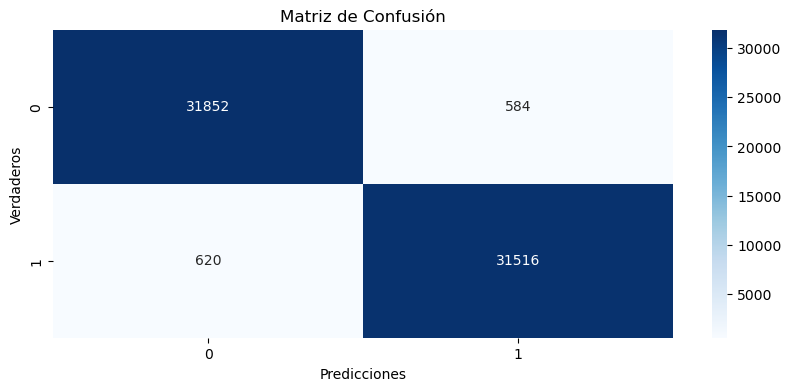

In [135]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.show()

Observamos que pese a tener un 10% mas de datos, los falsos positivos y negativos permanecen parecidos a los que hemos visto con los valores reales lo que nos confirma el exito del modelo de clasificacion usando los valores sintéticos generados por el modelo de regresión polinomica.

## Conclusiones

Tras la realización de este proyecto hemos visto primero, un análisis de datos del videojuego league of legends. Datos que eran bastante buenos, con poca limpieza por hacer en la que he realizado la limpieza vista en las anteriores entregas y he mejorado / completado el análisis exploratorio de las variables ya que para las regresiones mi variable objetivo cambiaba respecto al resto de entregas. Gracias a este análisis he podido escoger de la mejor forma las variables para ser capaz de predecir el porcentage de oro generado en una partida y poder analizar que factores influyen con mayor importancia en ello obteniendo unos resultados altamente satisfactorios.

En cuánto a los algoritmos, voy a hacer un breve resumen de lo que hemos aprendido de cada uno de ellos:

* Regresión Lineal: En la regresión lineal es donde tenia más curiosidad por saber que tan bien se ajustaria el modelo de una sola variable independiente a mis datos. Puesto que la variable usada parecia tener una gran correlacion lineal con la variable objetivo y asdemás así me evitaria probleas de colinealidad. Me he encontrado con un buen modelo, que sin embargo, ha sido fácilmente superado por el modelo creado usando 3 variables independientes que pese a su colinealidad han resultado en la creación de un modelo de 0.95 de r-squared.

* Regresión Polinomica: Este ha sido el modelo en el que he obtenido el mejor resultado, una vez más el modelo univariante presentaba un buen ajuste, sin embargo ha sido con el multivariante con el que he logrado un r-squared de 0.96. Sin embargo aqui hay algo importante a mencionar, este modelo ha tardado más de tres veces el tiempo que ha tardado el modelo de regresión lineal, así que aunque en este caso nos dé igual ya que ha sido menos de un segundo igualmente, habrá que ir con cuidado si se usan muchas más muestras.

* Árboles de Regresión: Este algoritmo podriamos decir que ha sido el más discreto, pese a presentar el mejor modelo univariante, el multivariante no ha podido superar al de la regresión polinomica, y con un tiempo de entrenamiento parecido a este y una mayor dificultad para analizar los resultados me ha dejado con mal sabor de boca.

* Optativo: Lo observado aquí si que no me lo esperaba, tras crear el modelo de clasificacion con las muestras sin valores nulos he procedido a rellenar las muestras nulas y a volver a crear el modelo con las mismas características pero con ese 10% extra de datos que han sido generados 'artificialmente' con el modelo de regresión polinomica. Lo que se ha observado tras la creación de este segundo modelo de clasificación, ha sido que el modelo se ajustaba mejor a los datos con el 10% extra de valores autogenerados que sin ellos. Esto nos ha demostrado no solo una gran precisión en la clasificación, sino sobretodo el éxito del modelo de regresión. Lo que habrá pasado seguramente, es que algunos de los valores que se habrán eliminado salían un poco de la norma general, y al recrearlos con el modelo de regresión se habrán generado valores más fáciles de usar para el modelo de clasificación.

En conclusión, el modelo que mejor se ha adaptado a los datos tanto en cuanto a precisión como en menor error, ha sido el de regresión polinómica con las 3 variables independientes, sin embargo, el más óptimo ha resultado ser el de regresión lineal con las 3 variables también. Entonces para este caso me quedaria con el modelo polinómico, sin embargo si tuviera que trabajar con muchisimos más datos, tendría que considerar si ese menos de 1% de precisión me sería rentable a costa del triple de tiempo de computación.

